In [1]:
import scenicplus
import muon as mu
import pycisTopic
import pandas as pd
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt
import os
import pickle
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.pseudobulk_peak_calling import peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.lda_models import evaluate_models




out_dir = "outs"
os.makedirs(out_dir, exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)

/data/adrienne/phd/biohackathon_2025/scenicplus/src/scenicplus/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-05 17:06:18,368	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


!mkdir -p data
!wget -O data/fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/1.0.0/human_brain_3k/human_brain_3k_atac_fragments.tsv.gz
!wget -O data/fragments.tsv.gz.tbi https://cf.10xgenomics.com/samples/cell-arc/1.0.0/human_brain_3k/human_brain_3k_atac_fragments.tsv.gz.tbi
!wget -O data/cell_data.tsv https://raw.githubusercontent.com/aertslab/pycisTopic/polars/data/cell_data_human_cerebellum.tsv

In [2]:
print(pycisTopic.__version__)
#print(scenicplus.__version__)

2.0a0


In [3]:
fragments_dict = {
    "10PCW_central": "analysis_chen/results/chen_2024/chen_10wk_central/outs/atac_fragments.tsv.gz"
}

In [4]:
mdata = mu.read_h5mu('analysis_chen/results/chen_2024/chen_10wk_central/chen_10wk_central_6.h5mu')

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
mdata.obs

,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:scDblFinder_score,rna:scDblFinder_class,rna:leiden,rna:leiden_joint,rna:majorclass,rna:cell_type_age_cat,...,EpiTraceAge_iterative,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,age_bool,cell_type_age_cat,sub_cell_type_age_cat,variants
AAACAGCCAGCTTAGC-1,4068,9670.0,11.0,0.113754,0.002245,singlet,13,17,PRPC,PRPC_0.0,...,0.721088,1436,0.136428,0.067649,1307,0.146484,0.0,PRPC_0.0,PRPC_0.0,NaN
AAACATGCAGCTTACA-1,4060,11122.0,18.0,0.161841,0.002245,singlet,1,4,RGC,RGC_0.0,...,0.049887,1044,0.092394,0.323129,1032,0.151657,0.0,RGC_0.0,OFF_MGC_0.0,NaN
AAACCAACAATATACC-1,2462,5103.0,16.0,0.313541,0.004361,singlet,0,11,PRPC,PRPC_1.0,...,0.969388,2181,0.224337,0.787982,1971,0.187507,1.0,PRPC_1.0,PRPC_1.0,NaN
AAACCAACACCTAATG-1,3414,7376.0,2.0,0.027115,0.003115,singlet,3,8,PRPC,PRPC_0.0,...,0.638322,1039,0.169123,0.752834,971,0.130899,0.0,PRPC_0.0,PRPC_0.0,NaN
AAACCAACATCTAGCA-1,2570,5270.0,3.0,0.056926,0.002245,singlet,0,2,PRPC,PRPC_0.0,...,0.794785,1345,0.176632,0.300076,1221,0.140783,0.0,PRPC_0.0,PRPC_0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCCCAGGGAGGA-1,2516,4913.0,50.0,1.017708,0.002245,singlet,8,13,NRPC,NRPC_0.0,...,0.501134,905,0.119083,0.406274,880,0.142804,0.0,NRPC_0.0,NRPC_0.0,NaN
TTTGTCCCAGTTTGTG-1,4081,12403.0,33.0,0.266065,0.002242,singlet,2,12,RGC,RGC_0.0,...,0.124717,1534,0.120285,0.021542,1517,0.148149,0.0,RGC_0.0,RGC Precursor_0.0,NaN
TTTGTGGCAAATTCGT-1,2276,4124.0,13.0,0.315228,0.002245,singlet,0,2,PRPC,PRPC_0.0,...,0.716553,1223,0.143761,0.657596,1093,0.104642,0.0,PRPC_0.0,PRPC_0.0,NaN
TTTGTGTTCATTGCAA-1,2690,5527.0,3.0,0.054279,0.002245,singlet,0,2,PRPC,PRPC_1.0,...,0.861678,1740,0.212697,0.781557,1587,0.169405,1.0,PRPC_1.0,PRPC_1.0,NaN


In [6]:
cell_data = mdata.obs
cell_data.head()

,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:scDblFinder_score,rna:scDblFinder_class,rna:leiden,rna:leiden_joint,rna:majorclass,rna:cell_type_age_cat,...,EpiTraceAge_iterative,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,age_bool,cell_type_age_cat,sub_cell_type_age_cat,variants
AAACAGCCAGCTTAGC-1,4068,9670.0,11.0,0.113754,0.002245,singlet,13,17,PRPC,PRPC_0.0,...,0.721088,1436,0.136428,0.067649,1307,0.146484,0.0,PRPC_0.0,PRPC_0.0,NaN
AAACATGCAGCTTACA-1,4060,11122.0,18.0,0.161841,0.002245,singlet,1,4,RGC,RGC_0.0,...,0.049887,1044,0.092394,0.323129,1032,0.151657,0.0,RGC_0.0,OFF_MGC_0.0,NaN
AAACCAACAATATACC-1,2462,5103.0,16.0,0.313541,0.004361,singlet,0,11,PRPC,PRPC_1.0,...,0.969388,2181,0.224337,0.787982,1971,0.187507,1.0,PRPC_1.0,PRPC_1.0,NaN
AAACCAACACCTAATG-1,3414,7376.0,2.0,0.027115,0.003115,singlet,3,8,PRPC,PRPC_0.0,...,0.638322,1039,0.169123,0.752834,971,0.130899,0.0,PRPC_0.0,PRPC_0.0,NaN
AAACCAACATCTAGCA-1,2570,5270.0,3.0,0.056926,0.002245,singlet,0,2,PRPC,PRPC_0.0,...,0.794785,1345,0.176632,0.300076,1221,0.140783,0.0,PRPC_0.0,PRPC_0.0,NaN


In [7]:
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes.head()

,Chromosome,Start,End
0,chr1,0,248956422
1,chr2,0,242193529
2,chr3,0,198295559
3,chr4,0,190214555
4,chr5,0,181538259


In [8]:
cell_data['sample_id'] = '10PCW_central'

In [9]:
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = "atac:majorclass",
    #sample_id_col = "VSN_sample_id",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 10,
    normalize_bigwig = True,
    temp_dir = "/tmp",
    split_pattern = "-"
)

2025-09-05 17:06:26,313 cisTopic     WARNING  NaNs detected in atac:majorclass column. These will be converted to 'nan' string.
2025-09-05 17:06:26,336 cisTopic     INFO     Splitting fragments by cell type.
2025-09-05 17:07:46,607 cisTopic     INFO     generating bigwig files


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://set

In [10]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [11]:
bw_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bw_paths.update({v: p})

    
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

In [12]:
macs_path = "macs3"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'hs',
    n_cpu = 10,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05#,
    #_temp_dir = '/scratch/leuven/330/vsc33053/ray_spill'
)

2025-09-05 17:08:33,322	INFO worker.py:1724 -- Started a local Ray instance.
(pid=13611) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(pid=13611)   from pkg_resources import DistributionNotFound, get_distribution


(macs_call_peak_ray pid=13610) 2025-09-05 17:08:35,079 cisTopic     INFO     Calling peaks for RGC with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/RGC.fragments.tsv.gz --name RGC  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=13608) 2025-09-05 17:08:35,182 cisTopic     INFO     Calling peaks for nan with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/nan.fragments.tsv.gz --name nan  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=13609) 2025-09-05 17:08:35,214 cisTopic     INFO     Calling peaks for MG with macs3 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/MG.fragments.tsv.gz --name MG  --outdir outs/consensus_peak_calling/MACS --form

(pid=13610) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(pid=13610)   from pkg_resources import DistributionNotFound, get_distribution [repeated 7x across cluster]


In [13]:
# Other param
peak_half_width=250
path_to_blacklist="pycisTopic/blacklist/hg38-blacklist.v2.bed"
# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2025-09-05 17:10:33,217 cisTopic     INFO     Extending and merging peaks per class


2025-09-05 17:10:56,380 cisTopic     INFO     Normalizing peak scores
2025-09-05 17:10:56,583 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2025-09-05 17:11:24,344 cisTopic     INFO     Done!


In [14]:
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version

In [15]:
!pycistopic tss gene_annotation_list | grep Human

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
hsapiens_gene_ensembl	Human genes (GRCh38.p14)


In [16]:
!mkdir -p outs/qc
!pycistopic tss get_tss \
    --output outs/qc/tss.bed \
    --name "hsapiens_gene_ensembl" #\
    #--to-chrom-source genbank #\
    #--ucsc hg38

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "hsapiens_gene_ensembl"
  - biomart_host: "http://www.ensembl.org"
  - transcript_type: ['protein_coding']
  - use_cache: True
- Writing TSS annotation BED file to "outs/qc/tss.bed".


In [17]:
!head outs/qc/tss.bed | column -t

#   Chromosome  Start  End      Gene  Score  Strand          Transcript_type
MT  3306        3307   MT-ND1   .     +      protein_coding  
MT  4469        4470   MT-ND2   .     +      protein_coding  
MT  5903        5904   MT-CO1   .     +      protein_coding  
MT  7585        7586   MT-CO2   .     +      protein_coding  
MT  8365        8366   MT-ATP8  .     +      protein_coding  
MT  8526        8527   MT-ATP6  .     +      protein_coding  
MT  9206        9207   MT-CO3   .     +      protein_coding  
MT  10058       10059  MT-ND3   .     +      protein_coding  
MT  10469       10470  MT-ND4L  .     +      protein_coding  


In [18]:
fragments_dict

{'10PCW_central': 'analysis_chen/results/chen_2024/chen_10wk_central/outs/atac_fragments.tsv.gz'}

In [19]:
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
tss_bed_filename = os.path.join(out_dir, "qc", "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc')}/{sample}",
            sep=" ",
            file=fh,
        )

In [20]:
!pycistopic qc --fragments analysis_chen/results/chen_2024/chen_10wk_central/outs/atac_fragments.tsv.gz --regions outs/consensus_peak_calling/consensus_regions.bed --tss outs/qc/tss.bed --output outs/qc/10PCW_central


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/topic_binarization.py:318: RuntimeWarning: invalid value encountered in divide
  mean1 = np.cumsum(hist * bin_centers) / weight1
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/topic_binarization.py:319: RuntimeWarning: invalid value encountered in divide
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]


In [21]:
!bash pycistopic_qc_commands.txt 

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/topic_binarization.py:318: RuntimeWarning: invalid value encountered in divide
  mean1 = np.cumsum(hist * bin_centers) / weight1
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/topic_binarization.py:319: RuntimeWarning: invalid value encountered in divide
  mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]


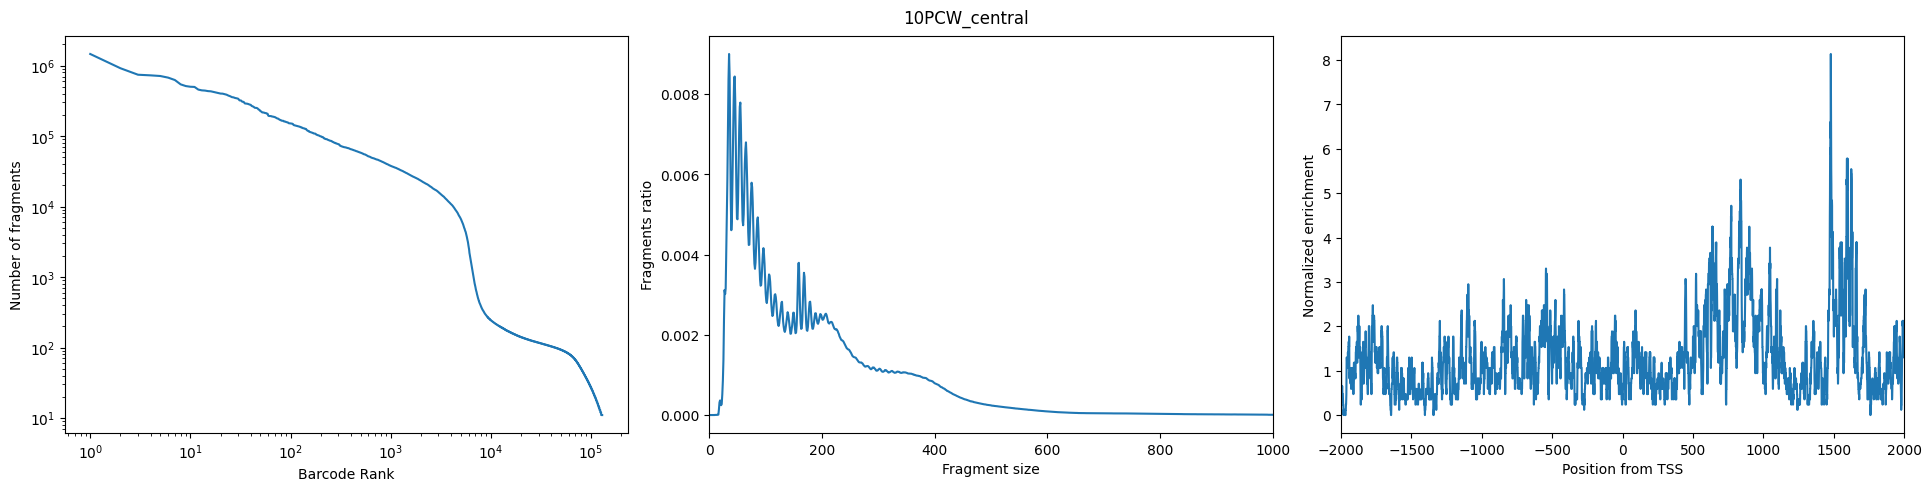

In [22]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc"
    )

In [23]:
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = "outs/qc",
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

10PCW_central:
	Using automatic threshold for unique fragments: 1332.8273997896881
	Using automatic threshold for TSS enrichment: 0.0001


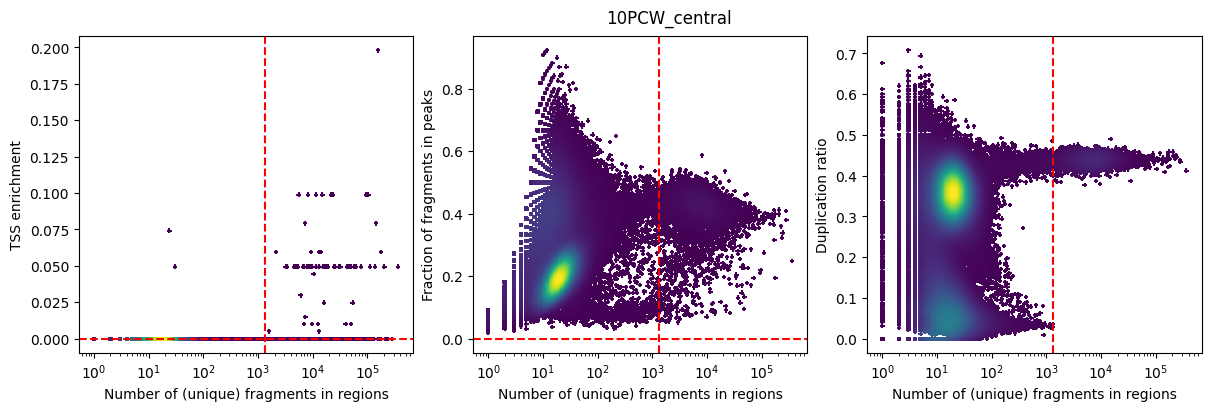

In [24]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "outs/qc",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [25]:
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = "pycisTopic/blacklist/hg38-blacklist.v2.bed"
pycistopic_qc_output_dir = "outs/qc"

from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 1,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2025-09-05 17:14:15,634 cisTopic     INFO     Reading data for 10PCW_central
2025-09-05 17:15:58,705 cisTopic     INFO     metrics provided!
2025-09-05 17:16:03,197 cisTopic     INFO     Counting fragments in regions
2025-09-05 17:16:05,292 cisTopic     INFO     Creating fragment matrix
2025-09-05 17:16:06,500 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 17:16:06,610 cisTopic     INFO     Removing blacklisted regions
2025-09-05 17:16:07,217 cisTopic     INFO     Creating CistopicObject
2025-09-05 17:16:07,483 cisTopic     INFO     Done!


In [26]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project 10PCW_central with n_cells × n_regions = 69 × 211067


In [27]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [28]:
import pandas as pd
cell_data = mdata.obs
cell_data.head()
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

Columns ['sample_id'] will be overwritten


In [29]:
cistopic_obj.cell_data

,cisTopic_log_nr_acc,cisTopic_nr_frag,total_fragments_in_peaks_count,duplication_count,cisTopic_nr_acc,barcode,cisTopic_log_nr_frag,pdf_values_for_duplication_ratio,log10_total_fragments_count,log10_total_fragments_in_peaks_count,...,Accessibility_iterative,AccessibilitySmooth_iterative,EpiTraceAge_Clock_initial,Accessibility_initial,AccessibilitySmooth_initial,age_bool,cell_type_age_cat,sub_cell_type_age_cat,variants,sample_id
TACCAAATCAGCCAAT-1-10PCW_central,4.775872,96303,168728,333978,59686,TACCAAATCAGCCAAT-1,4.98364,0.015622,5.890054,5.227190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTAACCAAGGTCCTGA-1-10PCW_central,4.812465,113735,199820,310522,64933,TTAACCAAGGTCCTGA-1,5.055894,0.012526,5.851596,5.300641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GGAGCATAGGCGGGTA-1-10PCW_central,4.193848,18865,33405,45291,15626,GGAGCATAGGCGGGTA-1,4.275657,0.340752,5.001846,4.523824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATTAACCCAGAACCGA-1-10PCW_central,4.880631,159273,278825,302562,75968,ATTAACCCAGAACCGA-1,5.202142,0.009563,5.838366,5.445333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAGCTTAAGGGTTATC-1-10PCW_central,3.942008,10154,17775,16388,8750,TAGCTTAAGGGTTATC-1,4.006637,0.742688,4.572744,4.249834,...,2414.0,0.276363,0.881330,2194.0,0.234120,1.0,PRPC_1.0,PRPC_1.0,chr16:46387709:T:C,10PCW_central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GATTTGCAGGGTTATC-1-10PCW_central,3.824711,7521,13052,12518,6679,GATTTGCAGGGTTATC-1,3.876276,0.791508,4.458048,4.115710,...,1425.0,0.078296,0.116024,1402.0,0.094487,1.0,RGC_1.0,RGC Precursor_1.0,NaN,10PCW_central
CCTCAAACAAACCTAT-1-10PCW_central,3.891035,8953,15373,14941,7781,CCTCAAACAAACCTAT-1,3.951969,0.670448,4.544824,4.186787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GGGTTTGTCTAGCTAA-1-10PCW_central,3.32838,2218,3887,4507,2130,GGGTTTGTCTAGCTAA-1,3.345962,0.321830,4.002296,3.589726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCACAGGGTTACATCC-1-10PCW_central,3.511349,3538,6084,5831,3246,CCACAGGGTTACATCC-1,3.548758,0.521028,4.133251,3.784261,...,919.0,0.162990,0.590703,838.0,0.138648,0.0,PRPC_0.0,PRPC_0.0,NaN,10PCW_central


!wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
!tar -xf Mallet-202108-bin.tar.gz

In [30]:
!mkdir -p mallet/chen_single/

In [31]:
os.environ['MALLET_MEMORY'] = '150G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu=12,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="mallet/chen_single/",
    save_path="mallet/chen_single/",
    mallet_path=mallet_path,
)

2025-09-05 17:16:09,926 cisTopic     INFO     Formatting input to corpus
2025-09-05 17:16:09,954 cisTopic     INFO     Running model with 2 topics
2025-09-05 17:16:09,955 LDAMalletWrapper INFO     Serializing temporary corpus to mallet/chen_single/corpus.txt
2025-09-05 17:16:10,482 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input mallet/chen_single/corpus.txt --output mallet/chen_single/corpus.mallet
2025-09-05 17:16:12,436 LDAMalletWrapper INFO     Training MALLET LDA with: Mallet-202108/bin/mallet train-topics --input mallet/chen_single/corpus.mallet --num-topics 2 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 12 --output-state mallet/chen_single/864389_state.mallet.gz --output-doc-topics mallet/chen_single/864389_doctopics.txt --output-topic-keys mallet/chen_single/864389_topickeys.txt --num-iterations 500 --inferencer-filename mallet/chen_single/864

In [32]:
pickle.dump(
    models,
    open(os.path.join(out_dir, "models.pkl"), "wb")
)

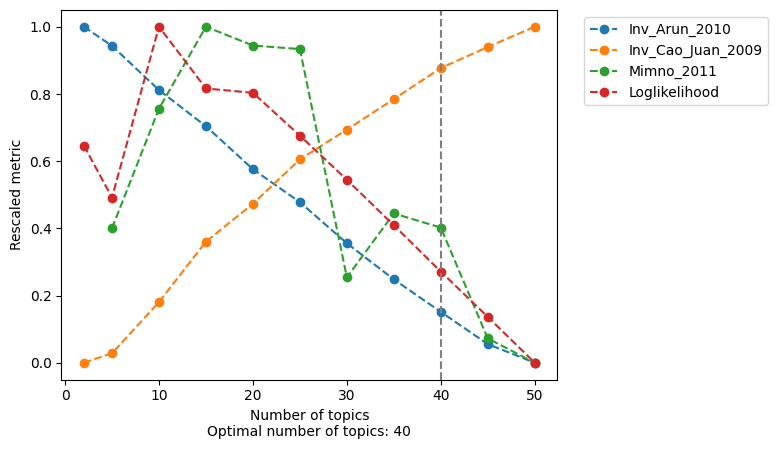

In [33]:
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [34]:
cistopic_obj.add_LDA_model(model)
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [35]:
cistopic_list = []
with open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb") as f:
    cistopic_list.append(pickle.load(f))